In [508]:
#!pip install --upgrade google-api-python-client
#!pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [509]:
import os 
from pprint import pprint
credentials = os.environ['api_key'] #https://developers.google.com/youtube/v3

first need to get james hoffman's `channelId`

In [510]:
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

api_service_name = "youtube"
api_version = "v3"

youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=credentials)

response = youtube.search().list(part='id', q='jameshoffmann', maxResults=1).execute()

pprint(response)

{'etag': 'xhXB9kj-bWRHj-fZTf5mjRdgn5Q',
 'items': [{'etag': 'lf1Ly6V1O6hk_gDajNpcRIcMSG4',
            'id': {'channelId': 'UCMb0O2CdPBNi-QqPk5T3gsQ',
                   'kind': 'youtube#channel'},
            'kind': 'youtube#searchResult'}],
 'kind': 'youtube#searchListResponse',
 'nextPageToken': 'CAEQAA',
 'pageInfo': {'resultsPerPage': 1, 'totalResults': 25494},
 'regionCode': 'IT'}


In [511]:
response = youtube.channels().list(part = "contentDetails, statistics",id = 'UCMb0O2CdPBNi-QqPk5T3gsQ').execute()
playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
pprint(response)

{'etag': 'HLcMVd48JdKzhzKanIH4dntHKKE',
 'items': [{'contentDetails': {'relatedPlaylists': {'likes': '',
                                                    'uploads': 'UUMb0O2CdPBNi-QqPk5T3gsQ'}},
            'etag': 'ymuD8EG7AzX3c1oGCRK979DchIw',
            'id': 'UCMb0O2CdPBNi-QqPk5T3gsQ',
            'kind': 'youtube#channel',
            'statistics': {'hiddenSubscriberCount': False,
                           'subscriberCount': '1780000',
                           'videoCount': '327',
                           'viewCount': '230820719'}}],
 'kind': 'youtube#channelListResponse',
 'pageInfo': {'resultsPerPage': 5, 'totalResults': 1}}


In [512]:
def get_video_ids(youtube, playlist_id):
    
    response = youtube.playlistItems().list(
        part = 'snippet, contentDetails', 
        playlistId=playlist_id, 
        maxResults=50
    ).execute()
    
    ids = {i['snippet']['title']:i['contentDetails']['videoId'] for i in response['items']}
    
    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        
        response = youtube.playlistItems().list(
            part = 'snippet, contentDetails', 
            playlistId=playlist_id, 
            maxResults=50,
            pageToken = next_page_token
        ).execute()
        
        next_page_token = response.get('nextPageToken')
        
        for i in response['items']:
            ids[i['snippet']['title']] = i['contentDetails']['videoId']
    
    return ids

retrieve all video ids on the channel

In [513]:
hoff_vids = get_video_ids(youtube, playlist_id)
len(set(hoff_vids))

327

In [514]:
hoff_vids

{'Coffee Roasting Explained': 'N6BJVM5tvnw',
 'The xBloom Review: Is Great Filter Coffee Easy Now?': 'hM1cP555xt4',
 'An Upgraded Vintage Lever Machine': 'hBdiBV-yzlk',
 'Can You Roast Coffee In Helium?': 'RhhkRsr6zJE',
 'The Best Coffee Toys Under $50': '5OFt2T8aH9I',
 'A Coffee Kickstarter Cautionary Tale': 'hnSUFXfRddE',
 "YouTube's Best Tiramisu (Ep #2)": '9536y-4Nl7A',
 'Coffee Pods Are Good For The Planet Now?!': 'i8B8wDsORz4',
 'The Fellow Ode 2: The Review': '3f8dv72Ex6U',
 'Solar Coffee Roasting: A Weird Desert Experiment': 'qV0bJHizJBA',
 'The Tiramisu: How It Became So Popular (Ep #1)': 'oWMbuTc7iIU',
 'Tasting Five Of The Best Tiramisus in Treviso (The Home of Tiramisu!)': 'uQQLpFdeDWM',
 'Caffeine Testing: Specialty vs Chains': '_HvsxuM7ljs',
 'I Did Caffeine Analysis: Some Unexpected Results!': 'etnMr8oUSDo',
 '1 Cup V60 Part 2: You Had A Lot Of Questions!': 'v5WQ1sZzW4o',
 'A Better 1 Cup V60 Technique': '1oB1oDrDkHM',
 'The Best USA 🇺🇸 Grocery Store Coffee': 'pfqvTCgglY

## Following cell won't work since you need permissions to get captions through YouTube API...

In [515]:
#okay let's get the captions from one of the videos 
from googleapiclient.http import MediaIoBaseDownload

def get_video_text(youtube, vid_id, file_dir="./"):
    # first get the caption id for en-GB caption track 
    response = youtube.captions().list(part='id, snippet', videoId = vid_id).execute()
    
    for i in response['items']:
        if i['snippet']['language'] == 'en-GB':
            caption_id = i['id']
    
    
    download_response = youtube.captions().download(
        id = caption_id,
        tfmt = 'sbv'
    ).execute()

    return 

In [8]:
#won't work since you don't have authorization
#get_video_text(youtube, list(hoff_vids.values())[0])

## Next ones should do the trick though :)

In [9]:
#!pip install yt-dlp

In [516]:
import yt_dlp

def download_captions(urls, path):
    ydl_opts = {'subtitle': '--write-sub --sub-lang en-GB',
               'writesubtitles': True,
               'skip_download':True,
                'paths':{'home': path}
               }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download(urls)
        
    return 

In [519]:
#download all these at once? nah lets do like 10 

to_url = lambda url: "https://www.youtube.com/watch?v="+url
urls = list(map(to_url, list(hoff_vids.values())))

download_captions([urls[0]], path = './subtitles/')

[youtube] Extracting URL: https://www.youtube.com/watch?v=N6BJVM5tvnw
[youtube] N6BJVM5tvnw: Downloading webpage
[youtube] N6BJVM5tvnw: Downloading android player API JSON
[info] N6BJVM5tvnw: Downloading subtitles: en
[info] N6BJVM5tvnw: Downloading 1 format(s): 22
[info] Writing video subtitles to: ./subtitles/Coffee Roasting Explained [N6BJVM5tvnw].en.vtt
[download] Destination: ./subtitles/Coffee Roasting Explained [N6BJVM5tvnw].en.vtt
[download] 100% of   35.86KiB in 00:00:00 at 322.31KiB/s


Now we gotta analyze the vtt files or whatever 
- maybe we can process these, delete the source, then write a smaller file back? unless neglibigle 

In [520]:
import re 
import string 

vtts = ['subtitles/'+f for f in os.listdir('subtitles')]
print(f'extracted captions for: {len(vtts)}/{len(hoff_vids)} videos')

def vtt_to_txt(vtt):
    with open(vtt) as f:
        lines = f.read()
    
    #gets rid of timestamps 
    lines = re.sub(r'\n\b\d{2}:\d{2}:\d{2}.\d{3}\b --> \b\d{2}:\d{2}:\d{2}.\d{3}\b\n', '', lines)
    
    #arbitrarily split up 
    lines = re.sub(r'\n', ' ', lines)
    
    #captions format 
    lines = re.sub('WEBVTT Kind: captions Language:', '', lines)
    lines = re.sub(r'\ben(-GB)?\b', '', lines, count=1)
    
    #get rid of closed captions [like this] and (like this)
    lines = re.sub(r'(\(|\[)\w+(\s?\w+)+?(\)|\])', '', lines)
    
    #misc stripping of white space and leading punctuation imbued by auto caption
    lines = lines.strip()
    lines = lines.strip(string.punctuation)
    lines = lines.strip()
    lines = '. '.join([l.strip() for l in lines.split('. ')[:-5]]) #lossy 
    lines+='.'
    
    return lines 
 
    

extracted captions for: 197/327 videos


In [521]:
from tqdm import tqdm 

get_vid_name = lambda x: re.match(r'.+(?=\[)', x.split('/')[1]).group().strip()
get_vid_id = lambda x:  re.findall(r'\[\S+\S\]', x)[0].strip(string.punctuation) #stupid since i already had these
vids = []

total_vid_sizes = 0

for vtt in tqdm(vtts):
    #check if the captions are in english & that size is sufficiently big 
    if os.path.getsize(vtt) < 5000 or '.en' not in vtt or vtt[-3:]!='vtt':
        continue 
    
    vids.append({'title':get_vid_name(vtt), 'text': vtt_to_txt(vtt), 'videoID':get_vid_id(vtt)})
    total_vid_sizes+=os.path.getsize(vtt)

print(f'now have: {len(vids)} videos')

100%|█████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 402.96it/s]

now have: 178 videos


In [522]:
print(f'We have {round(total_vid_sizes/(1e06),2)} MB of hoffman content')

We have 4.57 MB of hoffman content


(array([19., 28., 64., 27., 20.,  8.,  5.,  3.,  3.,  1.]),
 array([ 1238. ,  5441.4,  9644.8, 13848.2, 18051.6, 22255. , 26458.4,
        30661.8, 34865.2, 39068.6, 43272. ]),
 <BarContainer object of 10 artists>)

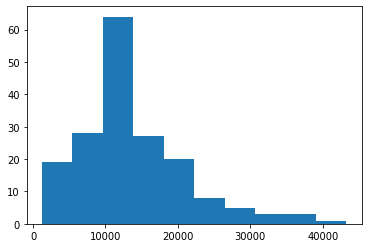

In [523]:
import matplotlib.pyplot as plt 

plt.hist([len(v['text']) for v in vids])

In [524]:
import numpy as np 

i = np.random.choice(range(len(vids)), 1)[0]
print(vids[i]['title']+'\n')
print(vids[i]['videoID']+'\n')
print(vids[i]['text'])

My WBC Winning Routine： Analysis, Tips, Tricks & Stories

DwZV17bek4

I wanted to do something a little bit different today It's been over ten years now since I last competed in barista competition but I thought it would be fun to go back and kind of watch through my performance as it was back then and Maybe explain a little bit about what was going on and some key things that I learnt from Competing from practicing that may be useful to you if you want to compete in barista championships Before we get started sadly there is not a high quality copy of this available This is the best there is and it's still pretty pixelated. So apologies for that and secondly, yes Yes, I did used to look ridiculous the hair the glasses the lot. I know I know just Just put it aside for a second. Forgive me in my past fashion indiscretions or whatever you want to say and let's get into Competing in Tokyo in 2007 in the world barista championship final. So Let's dive in It is with my great pleasure that I 

In [500]:
#we can check the dictionary here 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=True, stop_words = 'english').fit([v['text'] for v in vids])
len(vectorizer.vocabulary_)

11023

## Known issues or peculiarities:
- instances of 'pounds' instead the unicode symbol
- guest coffee youtubers who don't reflect the personality you're trying to distill (e.g. Decolonising Coffee Through Flavour)
- sponsor spiel 
- each video ends with the same "comment below and have a great day" -- remove this
- his british pronunciation is hard to pick up by auto subtitles sometimes 


In [525]:
#write to a json so I don't have to reload everything again
import json 

vid_json = json.dumps({'data':vids})

#!mkdir clean
with open('./clean/hoff.json', 'w') as f:
    f.write(vid_json)

In [526]:
#works 
with open('./clean/hoff.json') as f:
    clean = json.loads(f.read())

In [527]:
sum([len(v['text']) for v in vids])

2462617